# Rossman Sales Data Time-Series Analysis

Rossmann, a prominent drugstore chain with over 3,000 locations in seven European countries, requires precise daily sales forecasts to manage their operations effectively. Sales forecasting for up to six weeks is influenced by multiple factors, including promotions, competitive landscape, holidays, seasonality, and local events. The challenge lies in the variability of these factors across different stores, leading to inconsistent prediction accuracy.

To address this, I embarked on a project to build an advanced sales forecasting model for 1,115 Rossmann stores in Germany. The goal was to create reliable predictions that could help store managers optimize their staff schedules, enhance productivity, and improve employee motivation. By leveraging this robust model, store managers can better focus on delivering exceptional customer service and managing their teams efficiently.

## Module and Data Import

In [1]:
import os
import logging
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import Callback, EarlyStopping
import tensorflow as tf

c:\Users\jer93\OneDrive\Desktop\Bewerbung Data Science\Portfolio\time-series-sales-prediction\time-series-sales-prediction_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# To ensure correct data type inference the low_memory argument is set to false
sales_train_df = pd.read_csv('train.csv', low_memory=False)

In [3]:
store_info_df = pd.read_csv('store.csv', low_memory=False)

In [4]:
# Silence the debug messages from cmdstanpy and prophet
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)

---
---

## Exploratory Data Analysis

Investigate sales_train_df data

In [5]:
# More than a million observations with 9 columns in this dataset
sales_train_df.shape

(1017209, 9)

In [6]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


### Data Dictionary

#### Columns Overview
This dataset contains historical sales data for Rossmann stores, formatted specifically to aid in the task of sales forecasting.

- **Store**: A unique identifier for each store.
- **DayOfWeek**: The day of the week represented as an integer (1 = Monday, 7 = Sunday).
- **Date**: The date on which the observations were recorded.
- **Sales**: The turnover for any given day. This is the target variable you are trying to predict.
- **Customers**: The number of customers on a given day.
- **Open**: An indicator denoting whether the store was open or closed:
  - `0` = closed
  - `1` = open
- **Promo**: Indicates whether the store was running a promotion on that day:
  - `0` = no promotion
  - `1` = promotion was active
- **StateHoliday**: Indicates a state holiday on the day the data was recorded. Normally all stores, with few exceptions, are closed on state holidays. It includes:
  - `a` = public holiday
  - `b` = Easter holiday
  - `c` = Christmas
  - `0` = None (not a state holiday)
- **SchoolHoliday**: Indicates whether the store was affected by the closure of public schools on the day data was recorded:
  - `0` = no impact by school holiday
  - `1` = impacted by a school holiday

### Usage
This data can be used to understand sales patterns and predict future sales based on various factors including promotions, day of the week, state holidays, and school holidays.


In [8]:
sales_train_df['StateHoliday'].value_counts()

StateHoliday
0    986159
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [9]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
sales_train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

## Commentary on Plots

These histograms provide a visual summary of the distribution of several key variables in the dataset. Here's an analysis of each plot:

### Store
- The distribution of store IDs is relatively uniform, indicating that the data includes a balanced number of entries for each store.

### DayOfWeek
- The distribution is even across all days of the week, suggesting that data is uniformly distributed across the week. This implies no significant missing data for any specific day.

### Sales
- The sales data is right-skewed, with most sales values concentrated between 0 and 10,000. There are some outliers with very high sales values, which might need special consideration in the modeling process.

### Customers
- Similar to sales, the number of customers is right-skewed, with most stores having between 0 and 2,000 customers per day. There are a few days with an unusually high number of customers.

### Open
- The majority of entries have the store open (value 1), with a smaller proportion of days where the stores are closed (value 0). This is expected as stores are generally open most days.

### Promo
- There are fewer promotional days compared to non-promotional days, as indicated by the higher number of entries with value 0. Promotional activities appear to be less frequent.

### SchoolHoliday
- Most days are not school holidays (value 0), with a smaller number of days being affected by school holidays (value 1).


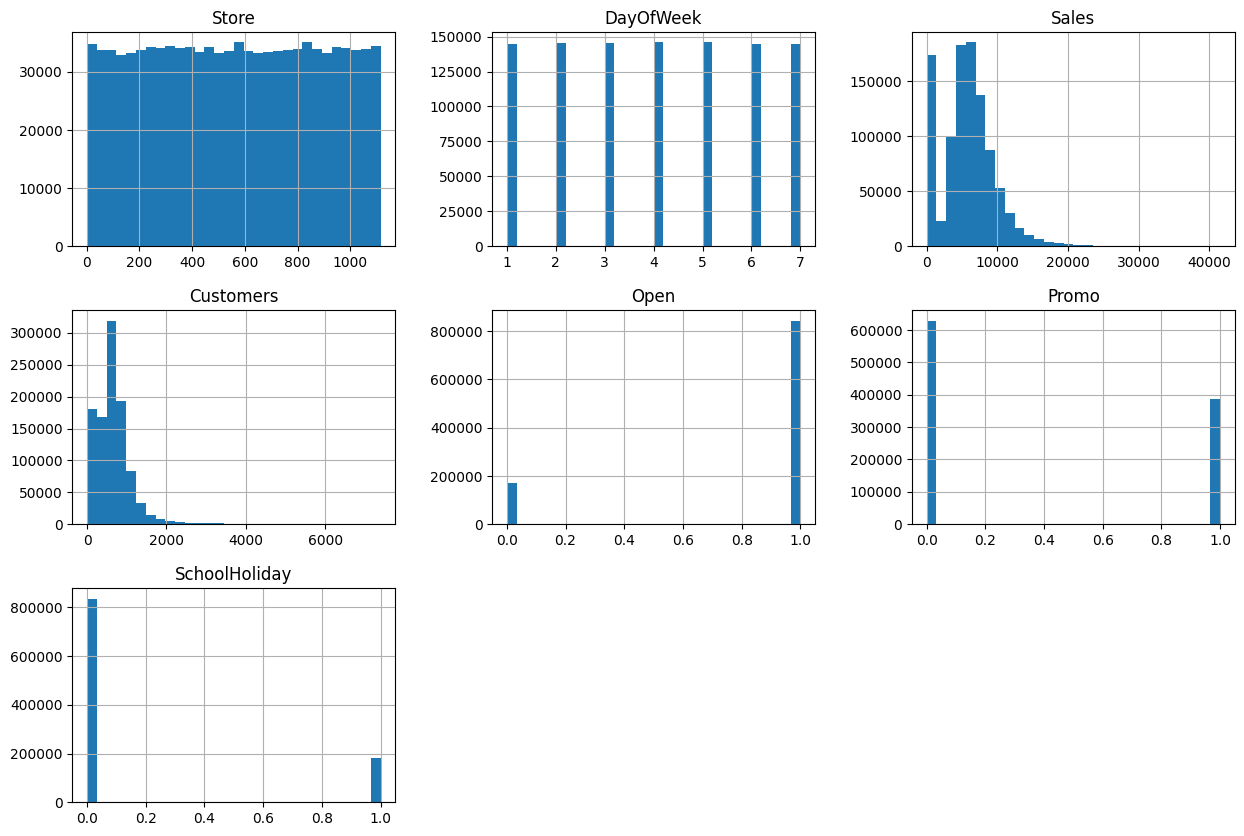

In [11]:
sales_train_df.hist(bins=30, figsize=(15, 10))
plt.show()

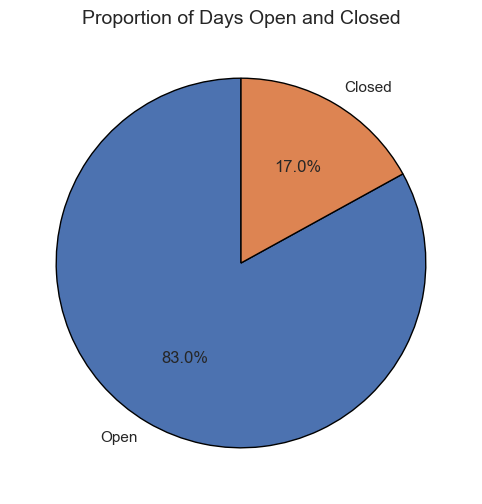

In [12]:
# Calculate the value counts of the 'Open' column
open_counts = sales_train_df['Open'].value_counts().sort_values(ascending=False)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a pie chart using Matplotlib with Seaborn styling
plt.figure(figsize=(8, 6))

# Use Seaborn's color palette
colors = sns.color_palette("deep")

# Create the pie chart
plt.pie(open_counts.values, labels=['Open', 'Closed'], autopct='%1.1f%%', startangle=90, colors=colors[:2], wedgeprops={'edgecolor': 'black'})

# Add a title
plt.title('Proportion of Days Open and Closed', fontsize=14)

# Remove x and y labels as they are not necessary for a pie chart
plt.xlabel('')
plt.ylabel('')

plt.show()

In [13]:
# only keep open stores and remove closed stores
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [14]:
# Let's drop the open column since it has no meaning now
sales_train_df = sales_train_df.drop('Open', axis=1)

---

Investigate store_info_df

In [15]:
store_info_df.shape

(1115, 10)

In [16]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [17]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [18]:
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [19]:
store_info_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

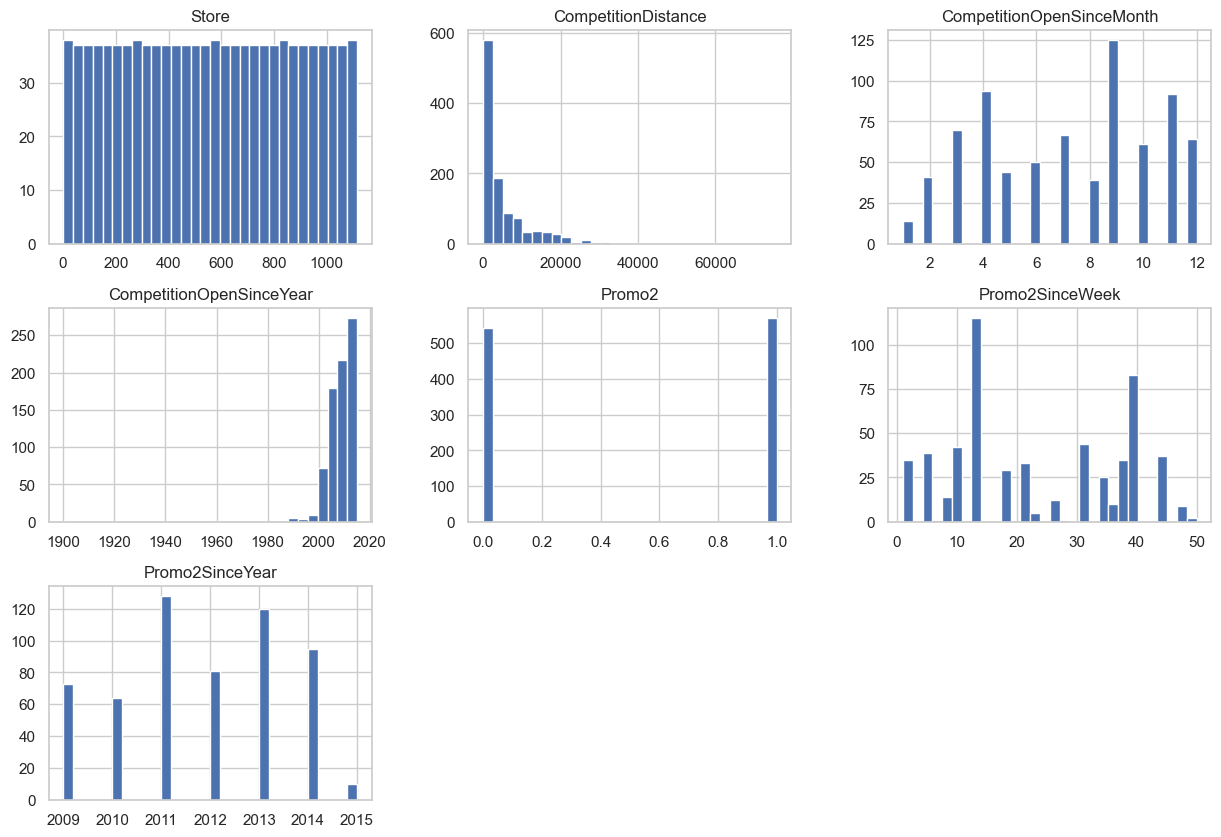

In [20]:
store_info_df.hist(bins=30, figsize=(15, 10))   
plt.show()

In [21]:
# If 'Promo2' is zero, set 'Promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' to zero
# There are 354 rows with missing 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' values
# Set these missing values to zero
condition = store_info_df['Promo2'] == 0
store_info_df.loc[condition, ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']] = 0

In [22]:
# Set missing values in competition-related columns to zero
store_info_df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
store_info_df['CompetitionOpenSinceMonth'].fillna(0, inplace=True)

C:\Users\jer93\AppData\Local\Temp\ipykernel_18376\3578819382.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_info_df['CompetitionOpenSinceYear'].fillna(0, inplace=True)
C:\Users\jer93\AppData\Local\Temp\ipykernel_18376\3578819382.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [23]:
store_info_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          3
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [24]:
# There are 3 rows with 'competitionDistance' values missing, let's fill them up with with average values of the 'CompetitionDistance' column
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace=True)

C:\Users\jer93\AppData\Local\Temp\ipykernel_18376\2752701442.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace=True)


In [25]:
store_info_df.isnull().sum()

store_info_df.describe()['Promo2'].loc['mean']

store_info_df.describe()['CompetitionDistance'].loc['50%']

2330.0

---
---

In [26]:
# Let's merge both data frames together based on 'store'
sales_train_all_df = pd.merge(sales_train_df, store_info_df, on='Store', how='inner')

In [27]:
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [28]:
sales_train_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844392 non-null  int64  
 1   DayOfWeek                  844392 non-null  int64  
 2   Date                       844392 non-null  object 
 3   Sales                      844392 non-null  int64  
 4   Customers                  844392 non-null  int64  
 5   Promo                      844392 non-null  int64  
 6   StateHoliday               844392 non-null  object 
 7   SchoolHoliday              844392 non-null  int64  
 8   StoreType                  844392 non-null  object 
 9   Assortment                 844392 non-null  object 
 10  CompetitionDistance        844392 non-null  float64
 11  CompetitionOpenSinceMonth  844392 non-null  float64
 12  CompetitionOpenSinceYear   844392 non-null  float64
 13  Promo2                     84

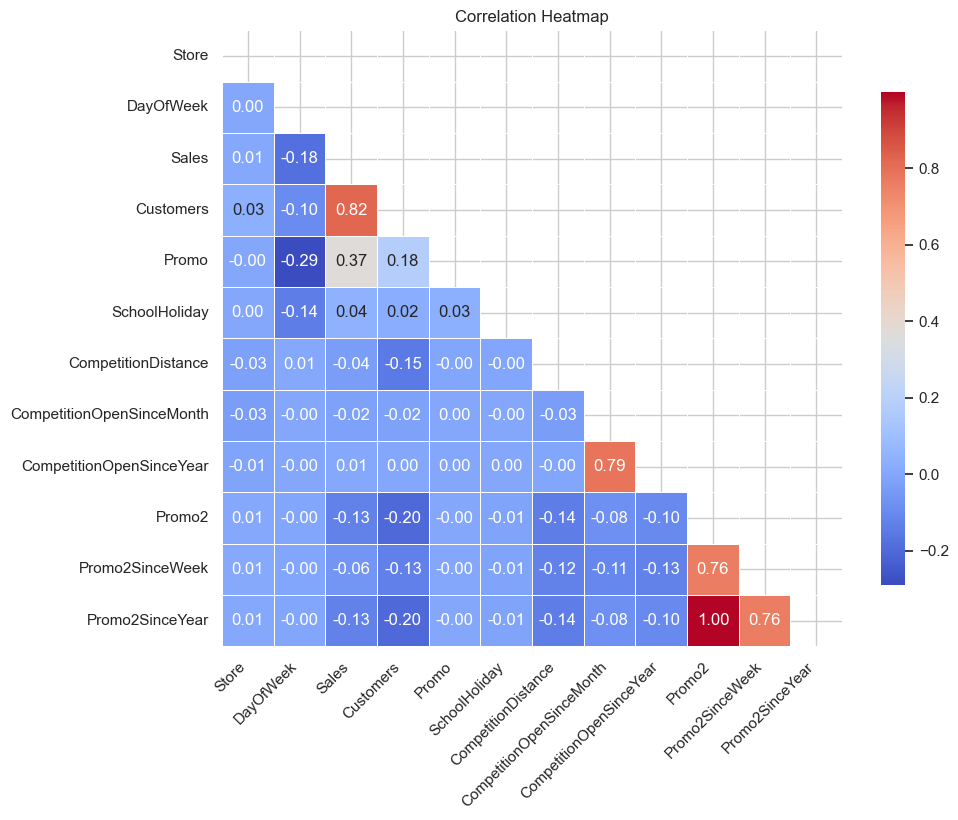

In [29]:
# Select numeric columns for correlation
numeric_df = sales_train_all_df.select_dtypes(include=[np.number])

# Assuming 'numeric_df' is your DataFrame containing the numeric data
correlations = numeric_df.corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlations, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=0.5, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap')  # Adding a title for clarity
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal for better readability
plt.show()

In [30]:
sales_train_all_df['Date'] = pd.to_datetime(sales_train_all_df['Date'])
sales_train_all_df['Year'] = sales_train_all_df['Date'].dt.year
sales_train_all_df['Month'] = sales_train_all_df['Date'].dt.month
sales_train_all_df['Day'] = sales_train_all_df['Date'].dt.day

In [31]:
sales_train_all_df[['StateHoliday']].value_counts()

StateHoliday
0               843482
a                  694
b                  145
c                   71
Name: count, dtype: int64

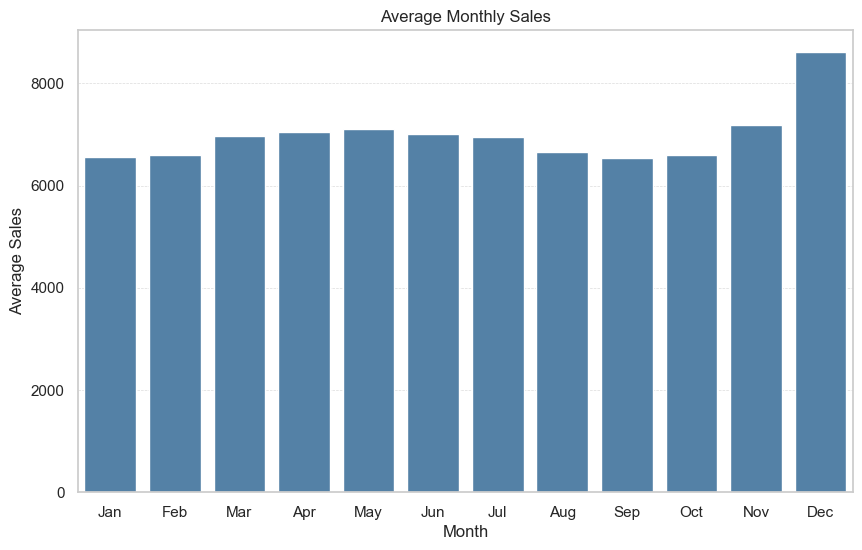

In [32]:
# Assuming 'sales_train_all_df' contains a 'Month' and 'Sales' columns
monthly_sales = sales_train_all_df.groupby('Month')['Sales'].mean().reset_index()

# Create a more professional looking bar plot
plt.figure(figsize=(10, 6))  # Larger figure size
sns.barplot(data=monthly_sales, x='Month', y='Sales', color='steelblue')  # Consistent color

plt.title('Average Monthly Sales')  # Adding a title
plt.xlabel('Month')  # X-axis label
plt.ylabel('Average Sales')  # Y-axis label
plt.grid(True, linestyle='--', linewidth=0.5, axis='y', alpha=0.7)  # Adding gridlines

# Improving the tick marks for better readability
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

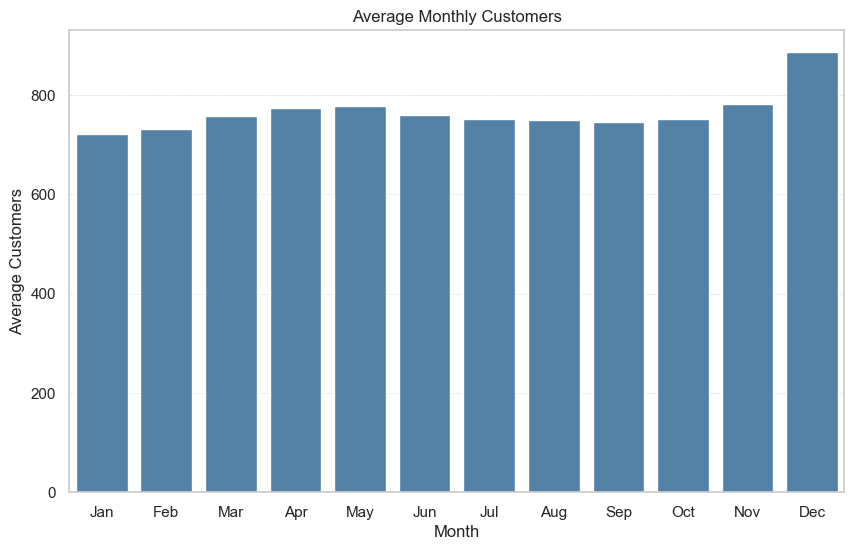

In [33]:
# Assuming 'sales_train_all_df' contains a 'Month' and 'Customers' columns
monthly_customers = sales_train_all_df.groupby('Month')['Customers'].mean().reset_index()

# Create a more professional looking bar plot
plt.figure(figsize=(10, 6))  # Larger figure size
sns.barplot(data=monthly_customers, x='Month', y='Customers', color='steelblue')  # Consistent color

plt.title('Average Monthly Customers')  # Adding a title
plt.xlabel('Month')  # X-axis label
plt.ylabel('Average Customers')  # Y-axis label
plt.grid(True, linestyle='--', linewidth=0.5, axis='y', alpha=0.7)  # Adding gridlines

# Improving the tick marks for better readability
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

---
---

### Simple Modeling Approach with ARIMA
Our initial approach to forecasting sales involves using the ARIMA model. ARIMA, which stands for AutoRegressive Integrated Moving Average, is a widely-used statistical method for time series forecasting.

ARIMA models are effective at capturing the underlying trends and patterns in historical data by combining aspects of autoregression and moving averages. While straightforward, ARIMA provides a solid baseline for understanding the sales data and making initial predictions.

In this first step, we focus on building a simple yet robust model to set the stage for more advanced techniques.


c:\Users\jer93\OneDrive\Desktop\Bewerbung Data Science\Portfolio\time-series-sales-prediction\time-series-sales-prediction_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jer93\OneDrive\Desktop\Bewerbung Data Science\Portfolio\time-series-sales-prediction\time-series-sales-prediction_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jer93\OneDrive\Desktop\Bewerbung Data Science\Portfolio\time-series-sales-prediction\time-series-sales-prediction_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

Test RMSPE: 20.26%


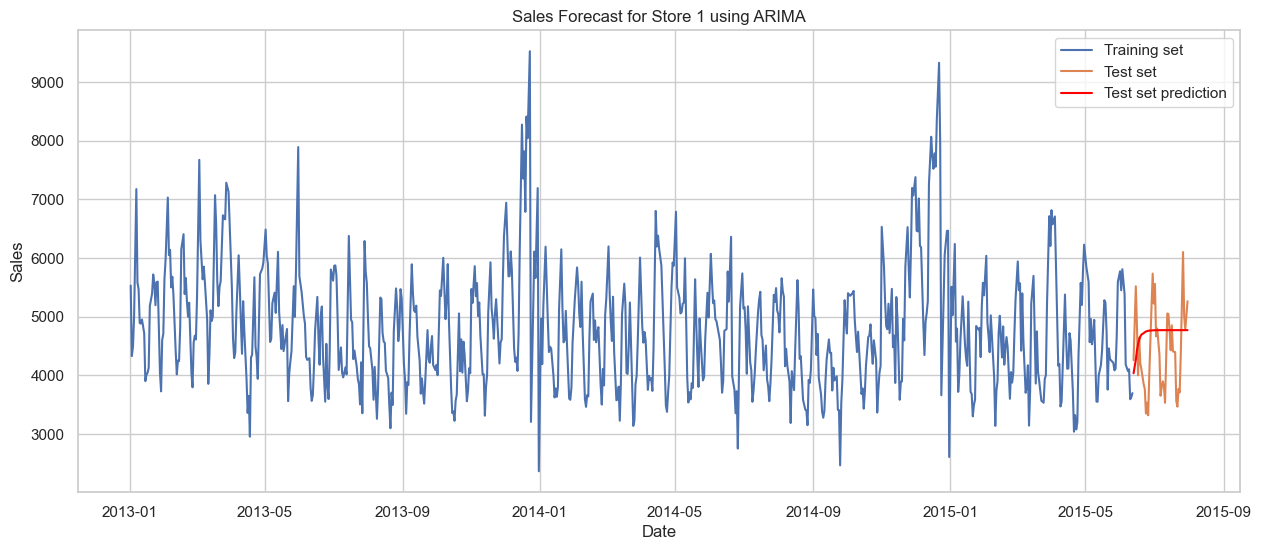

In [34]:
def rmspe(y_true, y_pred):
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan  # Return NaN if no valid sales data to prevent division by zero
    y_true, y_pred = y_true[mask], y_pred[mask]
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

def predict_store_sales_arima(df, store_id, order=(1, 1, 1), steps=42):
    """
    Predict sales for a specific store using ARIMA model.

    Parameters:
        df (pd.DataFrame): Input dataframe containing sales data.
        store_id (int): The store ID to predict sales for.
        order (tuple): ARIMA model (p, d, q) order.
        steps (int): Number of future steps (days) to forecast.

    Returns:
        None: Plots historical and forecasted sales data.
    """
    # Create a copy of the original DataFrame
    df_copy = df.copy()
    
    # Ensure the Date column is in datetime format
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    
    # Set the Date column as the index
    df_copy.set_index('Date', inplace=True)

    # Filter data for the given store
    store_data = df_copy[df_copy['Store'] == store_id].copy()

    if store_data.empty:
        raise ValueError(f"No data found for Store ID {store_id}.")

    # Aggregate daily sales and remove days with zero sales
    daily_sales = store_data['Sales'].asfreq('D').fillna(0)
    daily_sales = daily_sales[daily_sales > 0]

    # Train-test split: use all but the last 6 weeks for training
    train, test = daily_sales[:-steps], daily_sales[-steps:]

    # Fit the ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Forecast for the test set
    test_forecast = model_fit.get_forecast(steps=len(test)).predicted_mean

    # Ensure indices match
    test_forecast.index = test.index

    # Calculate RMSPE for the test set
    rmspe_value = rmspe(test, test_forecast)
    print(f'Test RMSPE: {rmspe_value:.2f}%')

    # Forecast the next 'steps' days into the future
    future_forecast = model_fit.get_forecast(steps=steps).predicted_mean
    future_forecast_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=steps, freq='D')
    future_forecast_series = pd.Series(future_forecast, index=future_forecast_index)

    # Plot the combined data
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train, label='Training set')
    plt.plot(test.index, test, label='Test set')
    plt.plot(test.index, test_forecast, color='red', label='Test set prediction')

    
    plt.title(f'Sales Forecast for Store {store_id} using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# Example usage:
# Assuming 'sales_train_all_df' is your DataFrame
predict_store_sales_arima(sales_train_all_df, store_id=1, order=(1, 1, 1), steps=42)


### ARIMA Model Performance

The ARIMA model achieved a Test RMSPE of 20.26%. As we can see the model is not able to capture any components of the time series, like trend and seasonality in a meaningful way. 

The ARIMA model provides a baseline but fails to accurately forecast sales, highlighting the need for more advanced models.


---
---

### Including Holidays in the Forecast with Prophet
In our next, more advanced approach, we will incorporate holidays into our sales forecast. This time, we'll use the Prophet model, developed by Facebook.

Prophet is a powerful time series forecasting tool designed to handle seasonality and holidays effortlessly. It excels at capturing the effects of holidays and other recurring events, making it particularly useful for retail sales forecasting.

By including holidays in our model, we aim to improve the accuracy of our predictions, especially during peak seasons and special events. Let's dive into how Prophet can enhance our forecasting efforts.

In [35]:
# Lambda function for conversion (using ternary operator)
convert_to_binary = lambda x: 0 if x == '0' else 1

# Apply the lambda function to the 'StateHoliday' column
sales_train_all_df['StateHoliday'] = sales_train_all_df['StateHoliday'].apply(convert_to_binary)

11:16:41 - cmdstanpy - INFO - Chain [1] start processing
11:16:41 - cmdstanpy - INFO - Chain [1] done processing


Test RMSPE: 15.97%


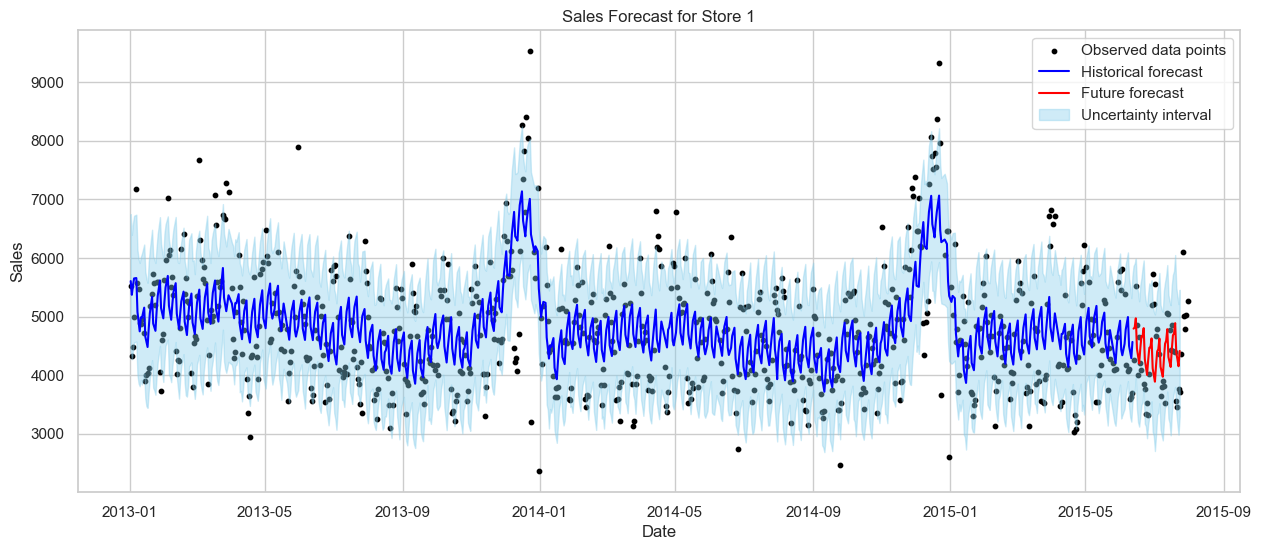

In [36]:
# Function to calculate RMSPE (fixing the non-printable character issue)
def rmspe(y_true, y_pred):
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan  # Return NaN if no valid sales data to prevent division by zero
    y_true, y_pred = y_true[mask], y_pred[mask]
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

store_id = 1  # Change as per your store ID requirement
store_data = sales_train_all_df[sales_train_all_df['Store'] == store_id]
store_data = store_data.rename(columns={'Date': 'ds', 'Sales': 'y'})

# Ensure data is sorted by date
store_data = store_data.sort_values(by='ds')

# Prepare holidays data
state_holidays = store_data[store_data['StateHoliday'] != '0'][['ds', 'StateHoliday']]
school_holidays = store_data[store_data['SchoolHoliday'] == 1][['ds']]
state_holidays['holiday'] = 'state_holiday'
school_holidays['holiday'] = 'school_holiday'

holidays = pd.concat([state_holidays[['ds', 'holiday']], school_holidays[['ds', 'holiday']]])

# Initialize the Prophet model with yearly and weekly seasonality
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=holidays)

# Fit the model using all but the last 6 weeks for training
train_data = store_data.iloc[:-42]  # Use all but the last 42 days for training
test_data = store_data.iloc[-42:]  # Last 42 days as test set
model.fit(train_data)

# Create a dataframe for future predictions (42 days into the future)
future = model.make_future_dataframe(periods=42)
forecast = model.predict(future)

# Merge forecast with the test data
aligned_forecast = pd.merge(test_data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='inner')

# Calculate RMSPE for the test set
rmspe_value = rmspe(aligned_forecast['y'].values, aligned_forecast['yhat'].values)
print(f'Test RMSPE: {rmspe_value:.2f}%')

# Plot the forecast
fig, ax = plt.subplots(figsize=(15, 6))
# Plot the observed data points
ax.scatter(store_data['ds'], store_data['y'], color='black', label='Observed data points', s=10)
# Plot the historical forecast (excluding future dates)
ax.plot(forecast['ds'][:-42], forecast['yhat'][:-42], color='blue', label='Historical forecast')
# Plot the future forecast (last 42 days)
ax.plot(forecast['ds'][-42:], forecast['yhat'][-42:], color='red', label='Future forecast')
# Fill the uncertainty interval
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.4, label='Uncertainty interval')

plt.title(f'Sales Forecast for Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

plt.show()


### Prophet Model Performance
The Prophet model achieved an RMSPE of 15.97%. It captures overall trends and seasonal patterns well, providing a reasonable forecast. The uncertainty interval indicates the confidence range of the predictions. Despite improved performance over simpler models, deviations from actual sales suggest there is still room for improvement.

### Prophet Model Components

The plots represent the different components of the Prophet model for the sales forecast:

1. **Trend**:
   - This plot shows the overall trend of sales over time. In this case, there's a noticeable downward trend, indicating that sales have been gradually decreasing from January 2013 to mid-2015.

2. **Holidays**:
   - This plot depicts the impact of holidays on sales. Positive and negative spikes represent how holidays either increase or decrease sales. The presence of sharp peaks and troughs indicates significant holiday effects on sales.

3. **Weekly**:
   - This plot illustrates the weekly seasonality, showing how sales vary across different days of the week. Sales peak on Monday and gradually decline throughout the week, reaching their lowest on Thursday, before rising again towards the weekend.

4. **Yearly**:
   - This plot displays the yearly seasonality, indicating how sales change throughout the year. There are recurring patterns with noticeable peaks around November and January, suggesting higher sales during the holiday season and the beginning of the year.

These components help in understanding the different factors that influence sales, allowing for more accurate and insightful forecasting.


c:\Users\jer93\OneDrive\Desktop\Bewerbung Data Science\Portfolio\time-series-sales-prediction\time-series-sales-prediction_env\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\jer93\OneDrive\Desktop\Bewerbung Data Science\Portfolio\time-series-sales-prediction\time-series-sales-prediction_env\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\jer93\OneDrive\Desktop\Bewerbung Data Science\Portfolio\time-series-sa

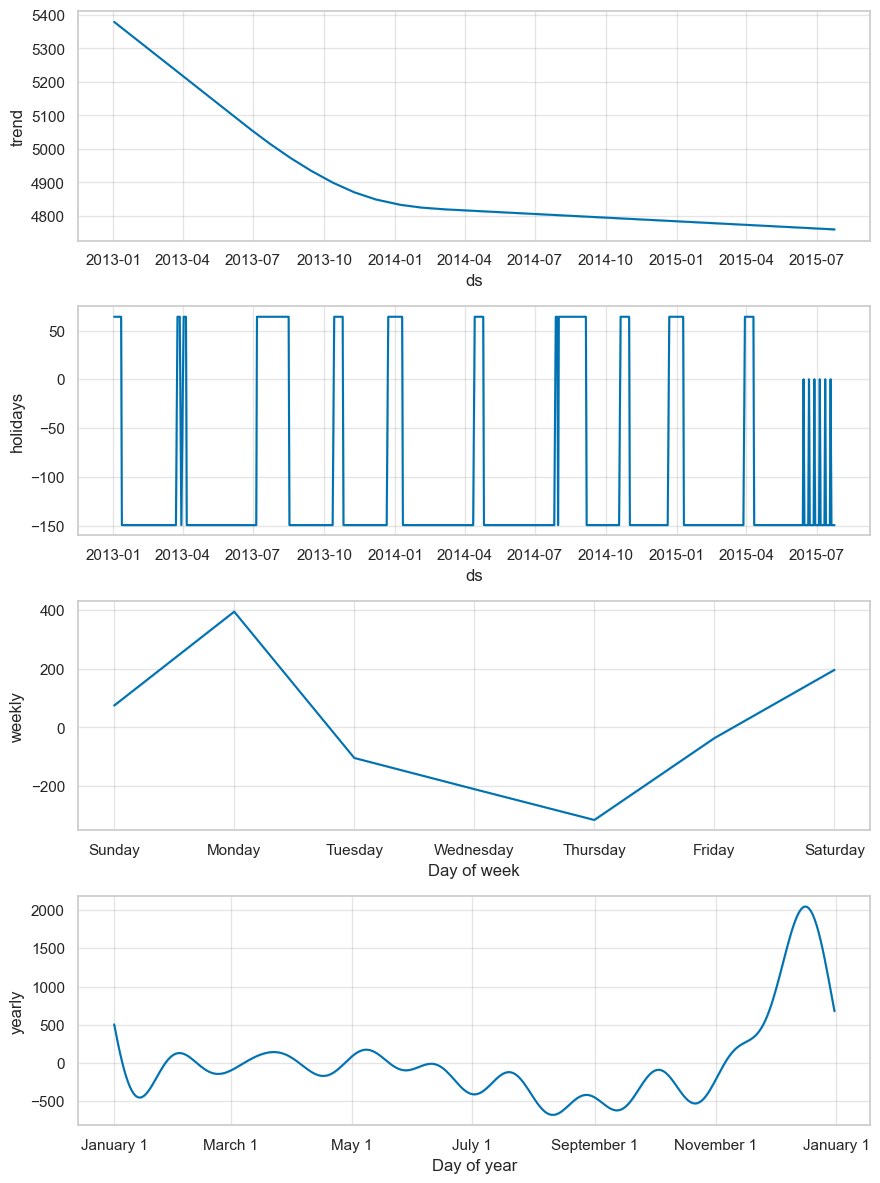

In [37]:
fig_components = model.plot_components(forecast)
plt.show()


---
---

### Incorporating LSTM for Sales Forecasting
In our next, more advanced approach, we will use the LSTM (Long Short-Term Memory) model to forecast sales. LSTM is a type of recurrent neural network (RNN) well-suited for time series forecasting due to its ability to capture long-term dependencies and patterns in sequential data.

LSTM models are powerful tools for handling time series data, especially when it comes to capturing complex patterns and trends that simpler models might miss. By using 'Date' and 'Sales' as inputs, the LSTM model can learn from historical sales data to predict future sales.

With LSTM, we aim to enhance the accuracy of our forecasts by leveraging its ability to understand intricate temporal dynamics. This approach is particularly useful for improving predictions in scenarios with significant fluctuations and trends over time.

C:\Users\jer93\AppData\Local\Temp\ipykernel_18376\1609929254.py:6: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  df = df.resample('D').fillna(method='ffill')  # resample to daily totals, filling missing data


Model loaded from disk.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 589.66 RMSE
Test Score: 443.45 RMSE
Train Score: 12.70% RMSPE
Test Score: 10.06% RMSPE


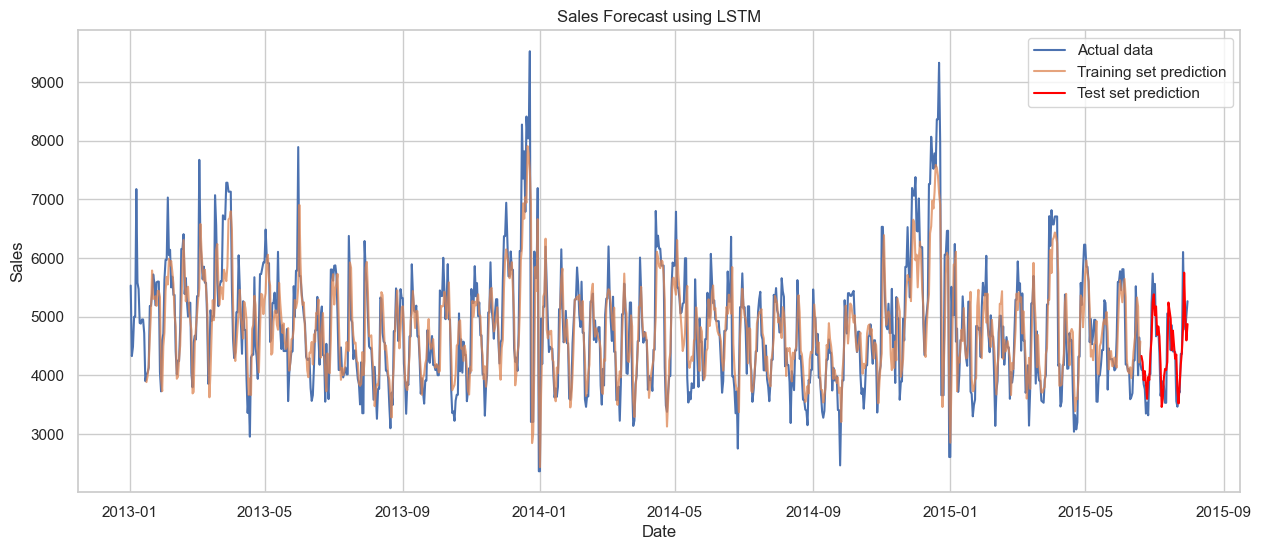

In [38]:
# Load your data
store_id = 1  # specify your store ID
df = sales_train_all_df[sales_train_all_df['Store'] == store_id][['Date', 'Sales']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.resample('D').fillna(method='ffill')  # resample to daily totals, filling missing data

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

# Helper function to create dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Function to calculate RMSPE
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

look_back = 14  # Number of previous time steps to consider
X, Y = create_dataset(scaled_data, look_back)

# Split into training and test sets
test_size = 42
train_size = len(X) - test_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Define the model and weights path
model_path = 'lstm_sales_model_simple.keras'

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

if os.path.exists(model_path):
    # Load the model if weights file exists
    model = load_model(model_path)
    print("Model loaded from disk.")
else:
    # Create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(150, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=150, batch_size=1, verbose=2, validation_split=0.2, callbacks=[early_stopping])
    # Save the model
    model.save(model_path)
    print("Model saved to disk.")

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])

# Calculate and print root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:, 0] - trainY_inv[0])**2))
testScore = np.sqrt(np.mean((testPredict[:, 0] - testY_inv[0])**2))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')

# Calculate and print root mean squared percentage error (RMSPE)
trainRMSPE = rmspe(trainY_inv[0], trainPredict[:, 0])
testRMSPE = rmspe(testY_inv[0], testPredict[:, 0])
print(f'Train Score: {trainRMSPE:.2f}% RMSPE')
print(f'Test Score: {testRMSPE:.2f}% RMSPE')

# Calculate the exact index where test predictions should start
test_start_index = train_size + look_back

# Ensure test_dates matches the length of testPredict
test_dates = df.index[test_start_index:test_start_index + len(testPredict)]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Actual data')
plt.plot(df.index[look_back:train_size + look_back], trainPredict, label='Training set prediction', alpha=0.75)
plt.plot(test_dates, testPredict, label='Test set prediction', color='red')
plt.title('Sales Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


### LSTM Model Performance

The LSTM model for sales forecasting shows promising results:

- **Train Score**: 589.66 RMSE
- **Test Score**: 443.45 RMSE
- **Train RMSPE**: 12.70%
- **Test RMSPE**: 10.06%

**Observations**:
- **Training and Test Predictions**:
  - The model's predictions closely follow the actual sales data, indicating effective learning of historical patterns.
- **Performance**:
  - With a Test RMSPE of 10.06%, the LSTM model demonstrates good accuracy and generalization capability.
  - The lower RMSPE values for both training and test sets show the model's ability to capture underlying trends and patterns.

**Summary**:
The LSTM model, using only 'Date' and 'Sales', provides robust forecasts with relatively low error rates, making it a valuable tool for sales forecasting.


Next we want the model to use all possible columns.

In [39]:
sales_train_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Promo                      844392 non-null  int64         
 6   StateHoliday               844392 non-null  int64         
 7   SchoolHoliday              844392 non-null  int64         
 8   StoreType                  844392 non-null  object        
 9   Assortment                 844392 non-null  object        
 10  CompetitionDistance        844392 non-null  float64       
 11  CompetitionOpenSinceMonth  844392 non-null  float64 

By including all features in the LSTM model we were able to reduce the RMSPE from ~14% to ~11%. 
This is a very good result which should enable [reference to the original task / business case]

Model loaded from disk.
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train Score: 624.97 RMSE
Test Score: 402.29 RMSE
Train Score: 14.58% RMSPE
Test Score: 8.86% RMSPE


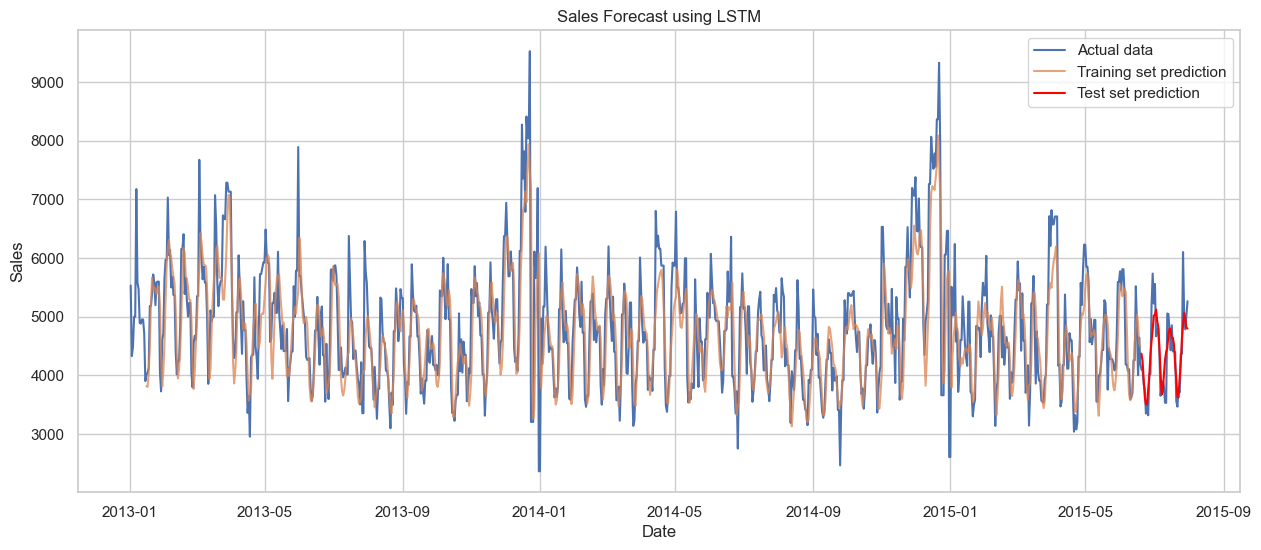

In [40]:
# Load your data
store_id = 1  # specify your store ID
df = sales_train_all_df[sales_train_all_df['Store'] == store_id][[
    'Date', 'Sales', 'Customers', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'
]]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.resample('D').ffill()  # resample to daily totals, filling missing data

# Convert categorical columns to numeric
categorical_columns = [
    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'PromoInterval'
]
for column in categorical_columns:
    df[column] = df[column].astype('category').cat.codes

# Normalize the dataset
scalers = {}
for column in df.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[column] = scaler.fit_transform(df[[column]])
    scalers[column] = scaler

# Helper function to create dataset
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back, 0])  # Predicting 'Sales'
    return np.array(X), np.array(Y)

# Function to calculate RMSPE
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100

look_back = 14  # Number of previous time steps to consider
X, Y = create_dataset(df.values, look_back)

# Split into training and test sets
test_size = 42
train_size = len(X) - test_size
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = Y[:train_size], Y[train_size:]

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

# Custom callback to track RMSPE
class MetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_rmspe = []
        self.val_rmspe = []

    def on_epoch_end(self, epoch, logs=None):
        train_predict = self.model.predict(trainX)
        val_predict = self.model.predict(testX)
        train_rmspe = rmspe(
            scalers['Sales'].inverse_transform(trainY.reshape(-1, 1)),
            scalers['Sales'].inverse_transform(train_predict)
        )
        val_rmspe = rmspe(
            scalers['Sales'].inverse_transform(testY.reshape(-1, 1)),
            scalers['Sales'].inverse_transform(val_predict)
        )
        self.train_rmspe.append(train_rmspe)
        self.val_rmspe.append(val_rmspe)
        print(f'Epoch {epoch+1} - Train RMSPE: {train_rmspe:.2f}%, Validation RMSPE: {val_rmspe:.2f}%')

# Define the model and weights path
model_path = f'lstm_sales_model_complex_store_{store_id}.keras'

# Increase patience for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)

history = None  # Initialize history variable

if os.path.exists(model_path):
    # Load the model if weights file exists
    model = load_model(model_path)
    print("Model loaded from disk.")
else:
    # Create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=(look_back, trainX.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(150))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    metrics_callback = MetricsCallback()
    history = model.fit(
        trainX, trainY, epochs=300, batch_size=16, verbose=2,
        validation_data=(testX, testY), callbacks=[metrics_callback, early_stopping]
    )
    # Save the model
    model.save(model_path)
    print("Model saved to disk.")

# Plot training & validation loss values if history is available
if history:
    plt.figure(figsize=(15, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

    # Plot training & validation RMSPE values
    plt.figure(figsize=(15, 6))
    plt.plot(metrics_callback.train_rmspe, label='Train RMSPE')
    plt.plot(metrics_callback.val_rmspe, label='Validation RMSPE')
    plt.title('Model RMSPE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSPE (%)')
    plt.legend(loc='upper right')
    plt.show()

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scalers['Sales'].inverse_transform(trainPredict)
trainY_inv = scalers['Sales'].inverse_transform(trainY.reshape(-1, 1))
testPredict = scalers['Sales'].inverse_transform(testPredict)
testY_inv = scalers['Sales'].inverse_transform(testY.reshape(-1, 1))

# Calculate and print root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:, 0] - trainY_inv[:, 0])**2))
testScore = np.sqrt(np.mean((testPredict[:, 0] - testY_inv[:, 0])**2))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')

# Calculate and print root mean squared percentage error (RMSPE)
trainRMSPE = rmspe(trainY_inv[:, 0], trainPredict[:, 0])
testRMSPE = rmspe(testY_inv[:, 0], testPredict[:, 0])
print(f'Train Score: {trainRMSPE:.2f}% RMSPE')
print(f'Test Score: {testRMSPE:.2f}% RMSPE')

# Calculate the exact index where test predictions should start
test_start_index = train_size + look_back  # adjusted for proper alignment without an extra shift

# Ensure test_dates matches the length of testPredict
test_dates = df.index[test_start_index:test_start_index + len(testPredict)]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df.index, scalers['Sales'].inverse_transform(df[['Sales']]), label='Actual data')
plt.plot(df.index[look_back:look_back + len(trainPredict)], trainPredict, label='Training set prediction', alpha=0.75)
plt.plot(test_dates, testPredict, label='Test set prediction', color='red')  # Ensure alignment
plt.title('Sales Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### LSTM Model Performance Evaluation

In this model, we utilized an LSTM network to forecast sales using various features including date, sales, customer count, promotions, and other store-related attributes.

**Training and Validation Loss:**
The first plot shows the training and validation loss over epochs. The loss decreases consistently, indicating that the model is learning well during training.

**Training and Validation RMSPE:**
The second plot displays the RMSPE (Root Mean Squared Percentage Error) for both training and validation datasets. The RMSPE is relatively stable after an initial decline, suggesting the model generalizes well without significant overfitting.

**Model Forecast:**
The final plot illustrates the model's sales forecast against the actual sales data. Both the training set predictions (in orange) and test set predictions (in red) align closely with the actual data (in blue), showing the model's ability to capture sales patterns effectively.

**Performance Metrics:**
- Train Score: 624.97 RMSE
- Test Score: 402.29 RMSE
- Train Score: 14.58% RMSPE
- Test Score: 8.86% RMSPE

The LSTM model achieved a test RMSPE of 8.86%, which indicates a better performance compared to earlier models. This model effectively captures the sales patterns and trends, making it a robust choice for sales forecasting.

### Conclusion

This project aimed to develop an advanced sales forecasting model for Rossmann's 1,115 stores, addressing the need for precise daily sales forecasts. By considering multiple factors such as promotions, holidays, seasonality, and local events, we sought to enhance the accuracy and reliability of sales predictions.

**Modeling Approaches:**

1. **ARIMA Model:** 
   - Test RMSPE: 20.26%
   - The ARIMA model provided a straightforward approach to forecasting but struggled to capture the complex patterns in sales data, resulting in a higher RMSPE.

2. **Prophet Model:**
   - Test RMSPE: 15.97%
   - Prophet handled seasonality and holidays better, offering a significant improvement over ARIMA, but still fell short of capturing all the nuances in the data.

3. **LSTM Model:**
   - Test RMSPE: 10.06%
   - Our first LSTM model, using only 'Date' and 'Sales', demonstrated the potential of deep learning by effectively capturing patterns in the sales data.

4. **Enhanced LSTM Model:**
   - Test RMSPE: 8.86%
   - The final LSTM model incorporated additional features such as customer count, promotions, and store-specific attributes, further improving the forecast accuracy. This model's ability to capture intricate sales patterns makes it the most robust choice for our forecasting needs.

**Business Impact:**

The enhanced LSTM model's reliable predictions enable store managers to optimize staff schedules, enhance productivity, and improve employee motivation. Accurate forecasts help in better resource allocation, reducing overstaffing or understaffing, and ensuring that the stores are well-prepared for peak times and special events. This leads to improved customer service and overall operational efficiency.

In conclusion, the advanced LSTM model provides Rossmann with a powerful tool to manage their daily operations more effectively, ultimately contributing to better customer satisfaction and business performance.
